In [1]:
import attr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.util import varsim
from statsmodels.tsa.vector_ar.var_model import VARResultsWrapper
from statsmodels.tools.validation import array_like, int_like


## Intervention Prediction

This notebook investigates the ability of a technique to use observational
data to predict the effect of a never-before-seen intervention.

### Systems

In [75]:
"""Derivative of the Lotka Volterra model"""
def lotka_volterra(u, t, params):
    # Model parameters.
    a, b, g, d = params
    # Current state.
    x, y = u

    # Evaluate differential equations.
    return [
        (a - b * y) * x, # prey
        (d * x - g) * y # predator
    ]


def keynesian_cross(u, t, params):
    """Deriviative of a Keynesian cross model."""
    a, b, G = params
    I, C = u
    return [
        I - a * C,  # Investment derivative
        b * (I - C - G)  # Consumption derivative
    ]

In [76]:
def apply_perfect_intervention(dF, idx: int, alpha: float):
    """
    Wraps the derivative of the system in a function that produces the
    evolution of the system in response to a perfect intervention where

        u[idx] = alpha (for all time)

    Args:
        dF: A function that describes a differential equation. Must accept
            three arguments, `u, p, t` where `u` is the state of the system
            `p` is an array of system parameters and `t` is the current time.
        idx: The index of the variable where the intervention should be applied.
        alpha: The value that the intervention assigns to `u[idx]`.
    """

    # Wrap the system in a function that applies the intervention
    def intervened_system(y, t, params):
        y_perf = y.copy()
        y_perf[idx] = alpha
        dX = dF(y_perf, t, params)
        dX[idx] = 0
        return dX

    # Return the intervened system
    return intervened_system

### Simulate perfect intervention with statsmodels VAR model

In [ ]:
def simulate_perfect_intervention_var(
    intervention_idx: int,
    intervention_value: float,
    coefs: np.ndarray,
    intercept: np.ndarray,
    sig_u: np.ndarray,
    steps: int =100,
    initial_values=None,
    seed=None,
    nsimulations=None

):
    """Simulate a perfect intervention applied to a VAR model.

    Args:
        var_result: The return value of VAR().fit(lags)
        intervention_idx: The index of the variable where the intervention
            will be applied.
        intervention_value: The value that the variable at inter_idx will be
            pinned to.
        coefs : ndarray
            Coefficients for the VAR lags of endog.
        intercept : None or ndarray 1-D (neqs,) or (steps, neqs)
            This can be either the intercept for each equation or an offset.
            If None, then the VAR process has a zero intercept.
            If intercept is 1-D, then the same (endog specific) intercept is
            added to all observations. If intercept is 2-D, then it is treated
            as an offset and is added as an observation specific intercept that
            may include trend, seasonality, etc., to the autoregression. In
            this case, the intercept/offset should have same number of rows as
            steps, and the same number of columns as endogenous variables 
            (neqs).
        sig_u : ndarray
            Covariance matrix of the residuals or innovations.
            If sig_u is None, then an identity matrix is used.
        steps : {None, int}
            number of observations to simulate, this includes the initial
            observations to start the autoregressive process.
            If offset is not None, then exog of the model are used if they were
            provided in the model
        initial_values : array_like, optional
            Initial values for use in the simulation. Shape should be
            (nlags, neqs) or (neqs,). Values should be ordered from less to
            most recent. Note that this values will be returned by the
            simulation as the first values of `endog_simulated` and they
            will count for the total number of steps.
        seed : {None, int}
            If seed is not None, then it will be used with for the random
            variables generated by numpy.random.
        nsimulations : {None, int}
            Number of simulations to perform. If `nsimulations` is None it will
            perform one simulation and return value will have shape (steps, neqs).
    """
    p, k, k = coefs.shape
    # Validate nsimulations
    nsimulations= int_like(nsimulations, "nsimulations", optional=True)
    if isinstance(nsimulations, int) and nsimulations <= 0:
        raise ValueError("nsimulations must be a positive integer if provided")
    if nsimulations is None:
        result_shape = (steps, k)
        nsimulations = 1
    else:
        result_shape = (nsimulations, steps, k)

    # Default for covariance
    if sig_u is None:
        sig_u = np.eye(k)

    # Default values and validation for intercept
    if intercept is not None:
        # intercept can be 2-D like an offset variable
        if np.ndim(intercept) > 1:
            if not len(intercept) == ugen.shape[1]:
                raise ValueError('2-D intercept needs to have length `steps`')
    
    # Validate initial values
    initial_values = array_like(
        initial_values,
        "initial_values",
        optional=True,
        maxdim=2
    )
    if initial_values is not None:
        if not (initial_values.shape == (p, k) or initial_values.shape == (k,)):
            raise ValueError("initial_values should have shape (p, k) or (k,) where p is the number of lags and k is the number of equations.")
            
    # Initialize the random seed
    rs = np.random.RandomState(seed=seed)

    # Draw noise from multivariate normal (mean zero and cov = sig_u)
    rmvnorm = rs.multivariate_normal
    ugen = rmvnorm(np.zeros(len(sig_u)), sig_u, steps*nsimulations)
    ugen = ugen.reshape(nsimulations, steps, k)

    # Initialize empty result array
    result = np.zeros((nsimulations, steps, k))

    if intercept is not None:
        # add intercept/offset also to intial values. When initial_values
        # is none, this makes the initial value equal to the offset

        # When the 
        result += intercept

    # Prep result array by adding noise before calculating recurrence 
    result[:,p:] += ugen[:,p:]

    # Set beginning of results equal to initial values
    if initial_values is not None:
        result[:,:p] = initial_values

    # Apply the intervention to the initial values
    result[:, :p, intervention_idx] = intervention_value

    # add in AR terms
    for t in range(p, steps):
        ygen = result[:,t]
        for j in range(p):
            ygen += np.dot(coefs[j], result[:,t-j-1].T).T
            # Overwrite ygen with the intervention
            ygen[:, intervention_idx] = intervention_value

    return result.reshape(result_shape)
    


### Tests

In [178]:
def test_intervention_function():
    dF = lambda y, p, t: y 
    idx = 2
    alpha = 3.0
    dF_inter = apply_perfect_intervention(dF, idx, alpha)

    # Test that the derivative on the intervened variable is zero
    assert dF_inter(np.random.rand(3), 0, 0)[idx] == 0

    y0 = np.random.rand(3)
    y0[idx] = alpha
    t = np.linspace(0, 10)
    Y = integrate.odeint(dF_inter, y0, t, args=(0.1,))
    
    # Test that the intervened variable maintains the same value
    assert np.all(Y[:, idx] == alpha)

def test_simulate_perfect_intervention_var():

    seed = 1
    rs = np.random.RandomState(seed)
    A1 = rs.rand(3, 3) - 0.5
    A2 = rs.rand(3, 3) - 0.5
    coefs = np.stack([A1, A2])
    mu = rs.rand(3)
    Z = rs.rand(3, 3)
    Sigma = Z * Z.T
    steps = 101
    initial_vals = np.ones((2, 3))
    nsims = 10000

    true_var_sim = varsim(
        coefs,
        mu,
        Sigma,
        steps=steps,
        initial_values=initial_vals,
        seed=seed,
        nsimulations=nsims,
    )

    intervention_idx = 3
    intervention_value = 10
    intervention_coefs = 0.5 * np.stack([np.eye(4), np.eye(4)])
    intervention_coefs[:, :3, :3] = coefs
    intervention_mu = rs.rand(4)
    intervention_mu[:3] = mu
    intervention_sigma = np.eye(4)
    intervention_sigma[:3, :3] = Sigma
    intervention_initial_vals = np.ones((2, 4))


    perf_inter_sim = simulate_perfect_intervention_var(
        intervention_idx,
        intervention_value,
        intervention_coefs,
        intervention_mu,
        intervention_sigma,
        steps=steps,
        initial_values=intervention_initial_vals,
        seed=seed,
        nsimulations=nsims,
    )

    assert true_var_sim.shape == perf_inter_sim[:, :, :3].shape
    assert np.all(perf_inter_sim[:, :, intervention_idx] == intervention_value)

    assert np.all(
        np.mean(true_var_sim - perf_inter_sim[:, :, :3], axis=0) < 0.1
    )

    # Do a third simulation to  double check that the above average doesn't hold
    # in general
    A1 = rs.rand(3, 3) - 0.5
    A2 = rs.rand(3, 3) - 0.5
    coefs = np.stack([A1, A2])
    mu = rs.rand(3)
    Z = rs.rand(3, 3)
    Sigma = Z * Z.T
    steps = 101
    initial_vals = np.ones((2, 3))
    nsims = 10000

    true_var_sim2 = varsim(
        coefs,
        mu,
        Sigma,
        steps=steps,
        initial_values=initial_vals,
        seed=seed,
        nsimulations=nsims,
    )

    assert not np.all(
        np.mean(true_var_sim - true_var_sim2, axis=0) < 0.1
    )
    
    
test_simulate_perfect_intervention_var()
test_intervention_function()

/Users/djpassey/Code/graphinference/graphinf_venv/lib/python3.9/site-packages/statsmodels/tsa/vector_ar/util.py:250: RuntimeWarning: covariance is not positive-semidefinite.
  ugen = rmvnorm(np.zeros(len(sig_u)), sig_u, steps*nsimulations).reshape(nsimulations, steps, k)


### Plot Example Intervention

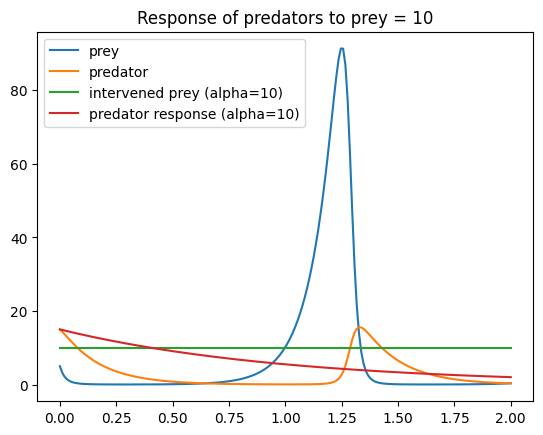

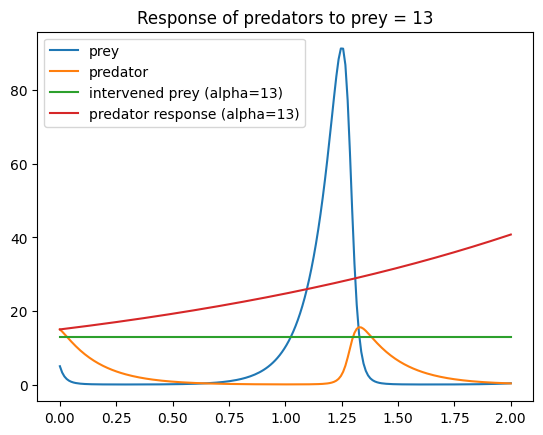

In [78]:
# Define initial-value problem.
y0 = [5.0, 15]
params = (10.0, 3.5, 6.0, 0.5)
t = np.linspace(0.0, 2, 200)
Y = integrate.odeint(lotka_volterra, y0, t, args=(params,))

# Plot simulation.
plt.plot(t, Y)

# Intervention 1
inter_idx = 0
alpha = 10
y0[inter_idx] = alpha
lk_inter = apply_perfect_intervention(lotka_volterra, inter_idx, alpha)
Y_inter = integrate.odeint(lk_inter, y0, t, args=(params,))
plt.plot(t, Y_inter)

plt.title("Response of predators to prey = 10")
plt.legend([
    "prey",
    "predator",
    "intervened prey (alpha=10)",
    "predator response (alpha=10)"
])
plt.show()

# Second intervention plot
plt.plot(t, Y)
# Intervention 2
inter_idx = 0
alpha = 13
y0[inter_idx] = alpha
lk_inter = apply_perfect_intervention(lotka_volterra, inter_idx, alpha)
Y_inter = integrate.odeint(lk_inter, y0, t, args=(params,))
plt.plot(t, Y_inter)


plt.title("Response of predators to prey = 13")
plt.legend([
    "prey",
    "predator",
    "intervened prey (alpha=13)",
    "predator response (alpha=13)",
])
plt.show()



### Class Describing the Perfect Intervention Problem

In [184]:
@attr.s
class PerfectInterventionProblem:
    """A class of variables needed to solve a perfect intervention problem.

    The perfect intervention problem is this: Let X(t) be a multivariate time
    series some system. Given a time interval [0, T], an initial condition,
    X_0, and a baseline value b, is it true that the time average of X_i(t) 
    is greater than b when a perfect intervention, X_j(t) = a for t in [0, T],
    is applied to X_j?

    Args:
        observations (np.ndarray): An (m, n) or (m, n, k) array of observations
            from a n dimensional multivariate time series. k represents the
            number of realizations
        times (np.ndarray): An (m,) or (m, k) array of time points
            corresponding to the observations.
        intervention_idx: (int) The index of the variable where the
            perfect intervention will be applied.
        intervention_value (float): The value that the intervened variable
            will be pinned to.
        intervention_initial_condition (np.ndarray): An n dimensional array
            containing the initial condition of the system when the perfect
            intervention is applied.
        response_idx (int): The index of the variable whose response to the
            intervention is to be predicted.
        response_baseline (float): The value that the time average of the
            response variable will be compared to. It can be any value,
            but in many cases it makes the sense for this variable to be the
            average of the response variable in the observations (which are from
            the non-intervened system).
        intervened_response_higher_than_baseline (bool): The ground truth
            solution to the intervention problem.
            
            This value is generated by simulating the application of the
            described perfect intervention to the true system, computing the
            time average of the response variabel and checking if it is greater
            than `response_baseline`.

            A method for solving the perfect intervention problem should use
            all other class attributes in order to predict this value. 
    """
    observations = attr.ib()
    times = attr.ib()
    intervention_idx = attr.ib()
    intervention_value = attr.ib()
    response_idx = attr.ib()
    response_baseline = attr.ib()
    intervened_target_higher_than_baseline = attr.ib()


### Build Demo Problems

In [185]:
# Define initial-value problem.
y0 = [5.0, 15]
params = (10.0, 3.5, 6.0, 0.5)
t = np.linspace(0.0, 100, 1000)
Y = integrate.odeint(lotka_volterra, y0, t, args=(params,))

# Add noise equal to a tenth the standard deviation of the trajectory
# of the deterministic time series
sigma = 0.1 * np.std(Y, axis=0)
observations = Y + sigma * np.random.randn(*Y.shape)

# Intervention 1
inter_idx = 0
alpha = 10
y0[inter_idx] = alpha
target_idx = 1
lk_inter = apply_perfect_intervention(lotka_volterra, inter_idx, alpha)
Y_inter = integrate.odeint(lk_inter, y0, t, args=(params,))
target_baseline_mean = np.mean(Y[:, target_idx])
intervened_target_mean = np.mean(Y_inter[:, target_idx])
answer = intervened_target_mean > target_baseline_mean

lotka_1 = PerfectInterventionProblem(
    observations,
    t,
    inter_idx,
    alpha,
    target_idx,
    target_baseline_mean,
    answer
)



# Intervention 2
inter_idx = 0
alpha2 = 13
y0[inter_idx] = alpha2
target_idx = 1
lk_inter2 = apply_perfect_intervention(lotka_volterra, inter_idx, alpha2)
Y_inter2 = integrate.odeint(lk_inter2, y0, t, args=(params,))
target_baseline_mean = np.mean(Y[:, target_idx])
intervened_target_mean2 = np.mean(Y_inter2[:, target_idx])
answer2 = intervened_target_mean2 > target_baseline_mean

lotka_2 = PerfectInterventionProblem(
    observations,
    t,
    inter_idx,
    alpha2,
    target_idx,
    target_baseline_mean,
    answer2
)




In [186]:
df = pd.DataFrame(lotka_1.observations, columns=["Prey", "Preadator"])
model = VAR(df)
results = model.fit(1)

In [15]:
problem = lotka_1

sim_var_Y_inter = simulate_perfect_intervention_var(
    problem.intervention_idx,
    problem.intervention_value,
    results.coefs,
    results.intercept,
    results.sigma_u,
    steps=len(problem.times),
    initial_values=problem.observations[0, :]
)

pred_ans = np.mean(sim_var_Y_inter[:, problem.response_idx]) > problem.response_baseline
print(f"Predicted: {pred_ans} \n Actual: {problem.intervened_target_higher_than_baseline}")

NameError: name 'lotka_1' is not defined

Set up the problem so you are at the fixed point of the system, 

System + initial condition + parameters + time

Write a simulate function that accepts args.

DynamicModel

Do we pass an initial condition to the LLM? Probably.

Problems

Methods

In [190]:
def f(x, *args, **kwargs):
    print(x)
    print(args)
    print(kwargs)

f(1, 2, 3, y=5, z=2)

1
(2, 3)
{'y': 5, 'z': 2}


In [ ]:
class DynamicModel:
    def simulate(
        self,
        initial_condition,
        time_points,
        intervention_func,
    ):
        """

        """
        time_series = np.zeros()

    def next_state(X, t, dt):
        """
        """
        pass

class ODE(DynamicModel):
    pass

class AgentBasedModel(DynamicModel):
    pass

class MarkovChain(DynamicModel):
    def simulate(
        intervention_func,
        intervention_idxs,
        transition_probs
    ):
        pass

I'm going to need to be able to simulate different dynamic models. I will want
to do multiple parameter settings and run counterfactuals by simulating the
model's response to interventions.

I want to do multiple runs of the same model and keep track of random seeds if
possible.

I want to tag the resulting time series with properties:
* non-linear
* stationary
* ergodic
* chaotic
* attracting fixed point
* measurement noise
* system noise
* discrete
* continuous
* hybrid

I want to set up the "predict the effect of an intervention problem"

Boils down to __two collections of time series__: 
$$
\{ \mathbf{x}^{(1)}(t), \mathbf{x}^{(2)}(t), \cdots  \mathbf{x}^{(p)}(t) \}
$$ and 
$$\{ \mathbf{x}_{\text{do }g}^{(1)}(t),
\mathbf{x}^{(2)}_{\text{do }g}(t), \cdots  \mathbf{x}_{\text{do }g}^{(p)}(t) \}
$$

To replicate this, we need the system pameters, the initial conditions,
the seeds and the intervention function. (If there is a time delay, extra
initial conditions are needed.)

Out of the two time series, we can construct inference problems.

In [ ]:

specs = {
    "model": LotkaVolteraMeasurementNoise,
    "model_params": {
        "alpha": 1.0,
        "beta": 2.3
    },
    "initial_conditions": LV_ics,
    "time_points": LV_tpts,
    "seeds": LV_seeds,
    "intervention_function": PerfectIntervention,
    "intervention_function_params": {
        "target_idx": 0,
        "target_value": 10
    },
    "tags": {
        "nonlinear": True,
        "ergodic": True,
        "chaotic": False,
        "stationary": True,
        "measurement_noise": True,
        "system_noise": False,
        "computational_graph": "",
        "intervention_explored": True,
    },
}

model = specs["model"](**specs["model_params"])
realizations = [
    model.simulate(
        initial_condition=ic,
        seed=s,
        intervention_function=None
    )
    for ic, s in zip(specs["initial_conditions"], specs["seeds"])
]

intervention_f = specs["intervention_function"](**specs["intervention_function_params"])
intervened_realizations = [
    model.simulate(
        initial_condition=ic,
        time_points=t,
        seed=s,
        intervention_function=intervention_f
    )
    for ic, t, s in zip(
        specs["initial_conditions"], specs["time_points"], specs["seeds"])
]


intervention_counterfactual = {
    "observations": realizations,
    "counterfactuals": intervened_realizations,
    "observation_time_points": specs["time_points"],
    "intervention_function": specs["intervention_function"],
    "intervention_function_params": specs["intervention_function_params"],
    "tags": specs["tags"],
}

If I was trying to use this package, what would I want? 

1. A JSON of specifications for every generated time series that I could download, read, import
   and then pass to a function to reproduce the simulated data. And run
   with different tweaks.
2. I would want all the dynamic models documented with clear explanations of the
   purpose and how it was used. i.e. what the model was designed to study and
   notable parameter values.
3. I would want intervention functions to be easy to make.
4. I would want to be able to easily simulate my own data.
5. Easily compute accuracy of a method that I made

In [ ]:
interfere

import extrapylation.counterfactual_dynamics as cfd
import extrapylation.methods as em

X, X_do = cfd.generate(
    **specs
)

multi_obs_counterfactual_dyn = cfd.multi_obs_generate(
    **specs
)

# It seems better to have a general model that can be parameterized
# by initialization arguments.
cfd.models.LotkaVoltera
cfd.models.MarkovChain
cfd.models.ThalamoCortical2018
cfd.models.UhlenbeckOrnstein

cfd.interventions.PerfectIntervention
cfd.interventions.ThresholdIntervention

predicted_X_do = em.VectorAutoRegression(X, x_do_0, g)




In [191]:

class DynamicModel:
    """Simple storage class for model parameters"""
    num_endogenous = attr.ib()
    num_exogenous = attr.ib()

    asdict = attr.asdict

In [192]:
DynamicModelParams(num_endogenous=2, num_exogenous=1, alpha=0.1)

TypeError: __init__() got an unexpected keyword argument 'alpha'

What if I assume that everything is discrete.

$$X(t_{i+1}) = F\Big( g \big( X(t_i), t_i \big) \Big)

Do I restrict to a continuous state space?

If I do continuous and binary, it should be good enough for many applications.
But I don't know what methods to use for that

### Risk Assessment Idea

Modeling uncertainty is important in many real applications. We can study this
process by simulating decision regarding systems in a situation where
there is risk.

We can compare algorithms

## LLM Generated Time series

In [105]:
col_names = """| Day | Sleep (hours) | Mood (1-10) | Spending (USD) | Exercise
(minutes) |"""

data = """| 1   | 7             | 6          | 50             | 30                |
| 2   | 6.5           | 5          | 40             | 20                |
| 3   | 8             | 7          | 60             | 40                |
| 4   | 7.5           | 6          | 55             | 35                |
| 5   | 6             | 4          | 45             | 15                |
| 6   | 7.5           | 7          | 65             | 45                |
| 7   | 7             | 6          | 60             | 30                |
| 8   | 6.5           | 5          | 50             | 25                |
| 9   | 7             | 6          | 55             | 35                |
| 10  | 8             | 7          | 70             | 40                |
| 11  | 7.5           | 6          | 60             | 35                |
| 12  | 6.5           | 5          | 45             | 20                |
| 13  | 7.5           | 7          | 65             | 45                |
| 14  | 7             | 6          | 55             | 30                |
| 15  | 6.5           | 5          | 50             | 25                |
| 16  | 8             | 7          | 70             | 40                |
| 17  | 7             | 6          | 60             | 35                |
| 18  | 7.5           | 6          | 55             | 30                |
| 19  | 6.5           | 5          | 45             | 20                |
| 20  | 7.5           | 7          | 65             | 45                |
| 21  | 6             | 4          | 50             | 15                |
| 22  | 7             | 6          | 60             | 30                |
| 23  | 8             | 7          | 70             | 40                |
| 24  | 7.5           | 6          | 55             | 35                |
| 25  | 6.5           | 5          | 45             | 20                |
| 26  | 7.5           | 7          | 65             | 45                |
| 27  | 7             | 6          | 55             | 30                |
| 28  | 6.5           | 5          | 50             | 25                |
| 29  | 8             | 7          | 70             | 40                |
| 30  | 7.5           | 6          | 60             | 35                |"""

In [112]:
data = np.array([
    [float(v.strip()) for v in d.strip().split("|") if v.strip()]
    for d in data.split('\n')
])
data

array([[ 1. ,  7. ,  6. , 50. , 30. ],
       [ 2. ,  6.5,  5. , 40. , 20. ],
       [ 3. ,  8. ,  7. , 60. , 40. ],
       [ 4. ,  7.5,  6. , 55. , 35. ],
       [ 5. ,  6. ,  4. , 45. , 15. ],
       [ 6. ,  7.5,  7. , 65. , 45. ],
       [ 7. ,  7. ,  6. , 60. , 30. ],
       [ 8. ,  6.5,  5. , 50. , 25. ],
       [ 9. ,  7. ,  6. , 55. , 35. ],
       [10. ,  8. ,  7. , 70. , 40. ],
       [11. ,  7.5,  6. , 60. , 35. ],
       [12. ,  6.5,  5. , 45. , 20. ],
       [13. ,  7.5,  7. , 65. , 45. ],
       [14. ,  7. ,  6. , 55. , 30. ],
       [15. ,  6.5,  5. , 50. , 25. ],
       [16. ,  8. ,  7. , 70. , 40. ],
       [17. ,  7. ,  6. , 60. , 35. ],
       [18. ,  7.5,  6. , 55. , 30. ],
       [19. ,  6.5,  5. , 45. , 20. ],
       [20. ,  7.5,  7. , 65. , 45. ],
       [21. ,  6. ,  4. , 50. , 15. ],
       [22. ,  7. ,  6. , 60. , 30. ],
       [23. ,  8. ,  7. , 70. , 40. ],
       [24. ,  7.5,  6. , 55. , 35. ],
       [25. ,  6.5,  5. , 45. , 20. ],
       [26. ,  7.5,  7. ,

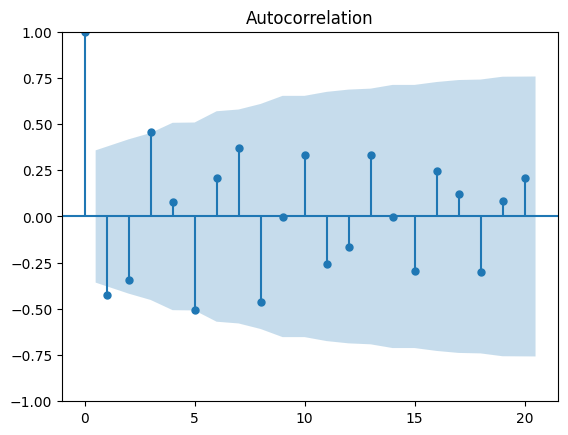

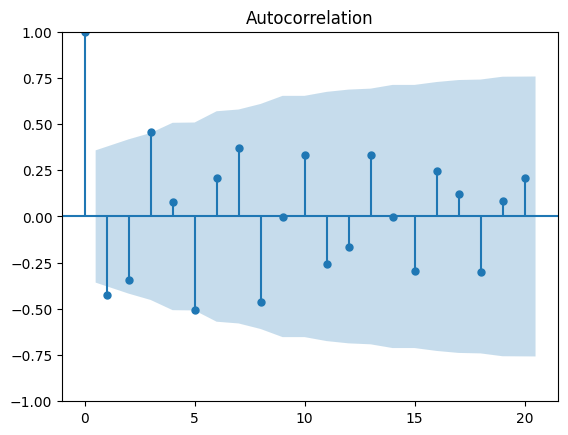

In [129]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data[:, 2], lags=20)
